<a href="https://colab.research.google.com/github/Ravemark/RecursiveAI-technical-interview-assignment/blob/main/Homework_Assignment_V4_Tim_Andersson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive technical homework

## Motivation
We hope you have fun doing this task as well as learn something new.

Do not be discouraged if you find the task challenging. Feel free to research as much as you want on Google or any other resource to solve this task. You are welcome to copy code snippets from stackoverflow, tutorials, blog posts, etc to help you finish the task. Make sure you understand them though :)

The goal is to push yourself a little and see how you like solving new problems using scientific computing and data analysis.

**About colab**

Please create a duplicate of this notebook using File > Save a Copy in Drive. Share your solution via a link to your local copy of the notebook.

You can solve the entirety of this task using a free kernel running in the cloud. Just click 'Connect' on the top right of the notebook. You can use any python libraries you want *unless* explicitly told to code your own algorithm. If a library you want to use is not already available from the colab runtime, go to 'Help' > 'Search code snippets' > Type 'Importing a library that is not in Colab' to learn how to install a library using pip.


# Part 1
Understanding Stochastic Gradient Descent.
In this exercise, we want to implement [Stochastic Gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) without using a built-in optimizer, to understand how parameters are optimized at the low level.

Let's consider a toy problem of [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). The data generation process is such that we have one floating point variable $x \in [0,1]$, and one categorical variable $y\in \{0,1\}$. The Logistic Regression problem is to find the optimal parameters for the logistic function to predict the probability of $y$ given $x$.

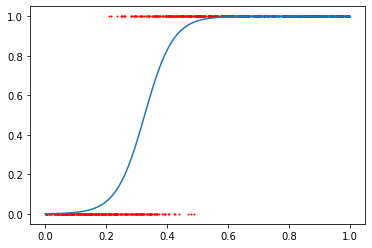

In the image above, the x and y axis correspond to the variables defined previously, with the red "dots" the true data as generated by the process defined below, and the blue line is the optimal logistic decision function learned from the data.

The optimal parameters can be found numerically using gradient descent. In this case, we will be using SGD (batched gradient descent) to optimize the two parameters in the logistic function, $\beta_1, \beta_2$.

If ${p(x)={\frac {1}{1+e^{-(\beta _{1}+\beta _{2}x)}}}}$, then we want to find $\beta_1, \beta_2$ such that the [negative log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) is minimized. In this case, ${\ell =\sum _{k=1}^{K}\left(\,y_{k}\ln(p_{k})+(1-y_{k})\ln(1-p_{k})\right)}$, and the SGD formula is simply:
$\beta_i = \beta_{i-1} - \alpha * \nabla \ell$.

The data generation process as well as the pseudo-code is provided for you below, your task is to fill in the appropriate pytorch code. *Do not use the built-in optimizer*, implement SGD using tensor operations alone.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

In [ ]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 32)
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)

learning_rate = 0.5

losses = []

for epoch in range(100): # Needs a high learning rate to reach a similar curve as in the example with few (15) epochs.
  epoch_loss = 0
  for x, y in zip(inputs, labels):
    # Calculate p_x as per formula above
    p_x = 1 / (1 + torch.exp(-(b1 + b2 * x))) # sigmoid function

    # Calculate the negative loss likelihood
    loss = -(y * torch.log(p_x) + (1 - y) * torch.log(1 - p_x)) #binary cross-entropy loss (=negative log likelihood)
    loss = torch.mean(loss)

    # Calculate the gradient of the loss w.r.t. the inputs
    loss.backward()

    # Update the parameters b according to SGD formula
    with torch.no_grad():
      # b = b - learning rate * gradient
      b1 -= learning_rate * b1.grad # Go in the negative direction of the training of the gradient
      b2 -= learning_rate * b2.grad

    # Zero the gradient
    b1.grad.zero_()
    b2.grad.zero_()
    epoch_loss = +loss.item()

  epoch_loss /= len(inputs)
  losses.append(epoch_loss)

    # Print out the loss value
  if epoch % 10 == 0:
    print(f"Epoch {epoch}, b1: {b1.item():.3f}, b2: {b2.item():.3f}, Loss: {loss.item():.8f}")

# Reproduce the image above to validate your result.

Epoch 0, b1: 0.091, b2: 1.502, Loss: 0.43750700
Epoch 10, b1: -2.165, b2: 6.933, Loss: 0.30263278
Epoch 20, b1: -3.011, b2: 9.289, Loss: 0.26892576
Epoch 30, b1: -3.543, b2: 10.817, Loss: 0.25257784
Epoch 40, b1: -3.931, b2: 11.948, Loss: 0.24266261
Epoch 50, b1: -4.235, b2: 12.841, Loss: 0.23592161
Epoch 60, b1: -4.484, b2: 13.573, Loss: 0.23100783
Epoch 70, b1: -4.693, b2: 14.191, Loss: 0.22725400
Epoch 80, b1: -4.872, b2: 14.721, Loss: 0.22428736
Epoch 90, b1: -5.028, b2: 15.182, Loss: 0.22188225


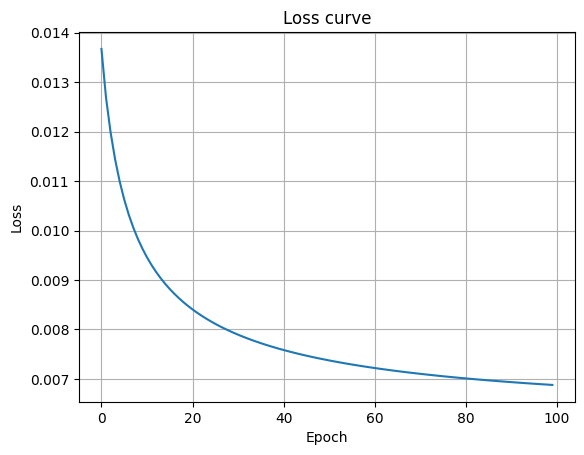

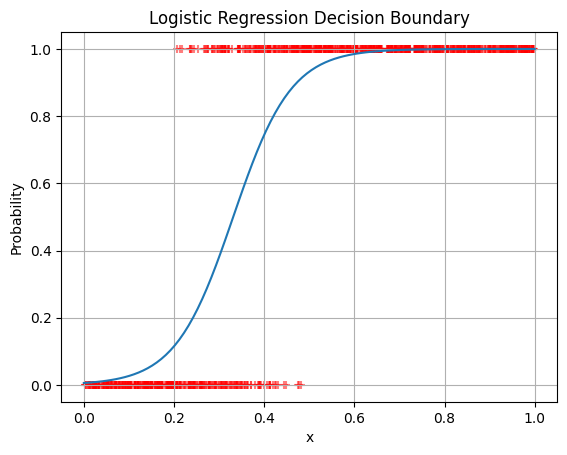

In [ ]:
# Plot decision boundary
x_vals = torch.linspace(0, 1, 100)
y_vals = 1 / (1 + torch.exp(-(b1 + b2 * x_vals)))

# Loss plot
plt.plot(losses)
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


plt.scatter(input.numpy(), label.numpy(), color='red', alpha=0.5, marker="+")
plt.plot(x_vals.numpy(), y_vals.detach().numpy())
plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Logistic Regression Decision Boundary")
plt.grid(True)
plt.show()

# Part 2-1

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
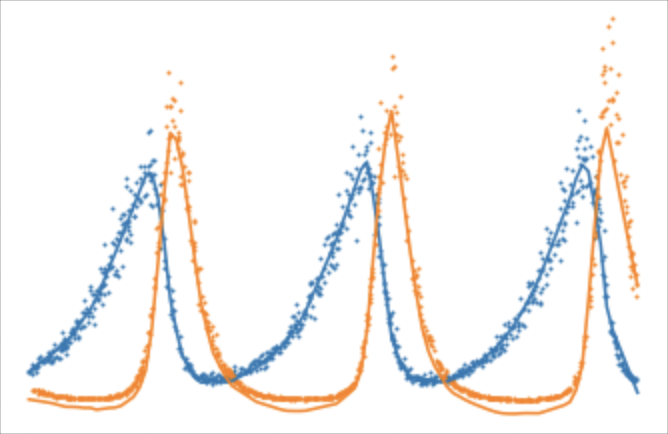

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
url = "https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv"
# df = pd.read_csv(url)

In [ ]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # no activation function, regression problem
        return x

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.data = pd.read_csv(url)
        self.data[['x', 'y']] = self.data[['x', 'y']].apply(pd.to_numeric, errors='coerce')

        # --- drop NaN Version ----
        # self.data = self.data.dropna()

        # --- Interpolation Version ----
        # self.data['x'] = self.data['x'].interpolate().bfill()
        # self.data['y'] = self.data['y'].interpolate().bfill()

        # --- Masked Version ----
        self.t = torch.tensor(self.data['t'].values, dtype=torch.float32).unsqueeze(1) # transform shape to the expected input format
        self.x = torch.tensor(self.data['x'].values, dtype=torch.float32)
        self.y = torch.tensor(self.data['y'].values, dtype=torch.float32)

        # inverted mask so True represents a valid value
        self.mask_x = ~torch.isnan(self.x)
        self.mask_y = ~torch.isnan(self.y)

        # turn NaN values into 0.0 floats
        self.x = torch.nan_to_num(self.x, nan=0.0)
        self.y = torch.nan_to_num(self.y, nan=0.0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.t[idx],
            torch.tensor([self.x[idx], self.y[idx]]),
            torch.tensor([self.mask_x[idx], self.mask_y[idx]])
        )

In [ ]:
def masked_loss_fn(predictions, targets, masks):

    mse_loss = (predictions - targets) ** 2

    # Applies the mask
    masked_loss = mse_loss * masks

    # Counts the nr of valid values in the mask (entries contributingh to the loss)
    valid_count = masks.sum()

    # For saftey, added an edge case collector.
    if valid_count == 0:
        return torch.tensor(0.0, requires_grad=True)

    # Sum of valid loss. Ensures loss is averaged over the valid entries
    loss = masked_loss.sum() / valid_count
    return loss

In [ ]:
BATCH_SIZE = 32

dataset = TimeSeriesDataset(url)
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

net = Net()

#TODO what is a good optimizer?
optimizer = optim.Adam(net.parameters(), lr=0.003)
# optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

# From what I've seen, Adam is the go-to.
# It also perfomed vastly better than the SGD optimizer I tried

In [ ]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, targets, mask = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = masked_loss_fn(outputs, targets, mask)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 7.731
[1,    40] loss: 7.460
[1,    60] loss: 7.364
[2,    20] loss: 6.829
[2,    40] loss: 6.903
[2,    60] loss: 6.832
[3,    20] loss: 7.132
[3,    40] loss: 6.105
[3,    60] loss: 6.436
[4,    20] loss: 5.621
[4,    40] loss: 6.120
[4,    60] loss: 6.538
[5,    20] loss: 5.270
[5,    40] loss: 6.193
[5,    60] loss: 5.789
[6,    20] loss: 5.441
[6,    40] loss: 5.349
[6,    60] loss: 5.530
[7,    20] loss: 5.278
[7,    40] loss: 5.123
[7,    60] loss: 5.263
[8,    20] loss: 5.468
[8,    40] loss: 5.438
[8,    60] loss: 4.154
[9,    20] loss: 5.359
[9,    40] loss: 4.476
[9,    60] loss: 4.908
[10,    20] loss: 4.134
[10,    40] loss: 4.646
[10,    60] loss: 5.656
[11,    20] loss: 4.487
[11,    40] loss: 4.703
[11,    60] loss: 5.408
[12,    20] loss: 5.420
[12,    40] loss: 3.831
[12,    60] loss: 5.369
[13,    20] loss: 4.589
[13,    40] loss: 4.754
[13,    60] loss: 4.904
[14,    20] loss: 4.836
[14,    40] loss: 4.533
[14,    60] loss: 4.600
[15,    20] loss: 4

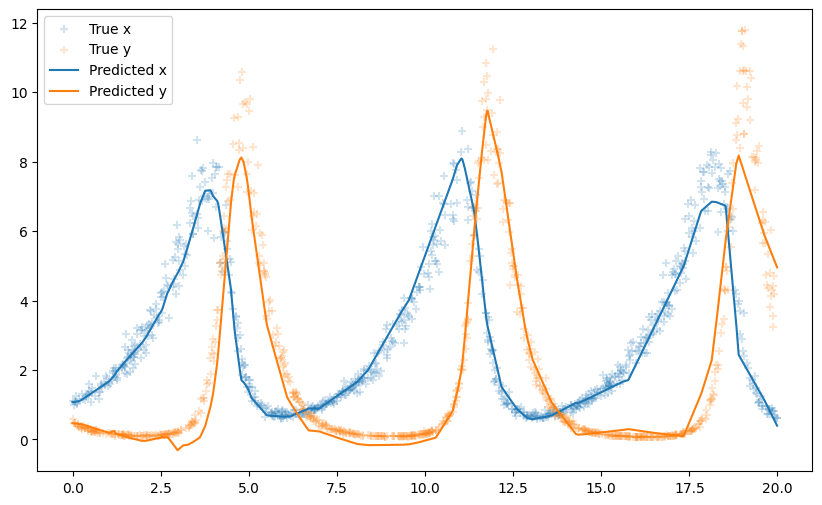

In [ ]:
# Visualize the results
net.eval()
with torch.no_grad():
    # time_tensor, xy_tensor = next(iter(trainloader))

    time_tensor = torch.cat([dataset.__getitem__(i)[0] for i in range(len(dataset))]).unsqueeze(1)
    xy_tensor = torch.stack([dataset.__getitem__(i)[1] for i in range(len(dataset))])

    xy_tensor[xy_tensor == 0.0] = float('nan')

    plt.figure(figsize=(10, 6))
    predictions = net(time_tensor).numpy()
    plt.scatter(time_tensor.numpy(), xy_tensor[:, 0].numpy(), label='True x', marker='+', alpha=0.2)
    plt.scatter(time_tensor.numpy(), xy_tensor[:, 1].numpy(), label='True y', marker='+', alpha=0.2)

    plt.plot(time_tensor.numpy(), predictions[:, 0], label='Predicted x', alpha=1)
    plt.plot(time_tensor.numpy(), predictions[:, 1], label='Predicted y', alpha=1)

    plt.legend()
    plt.show()

# Part 2-2 Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


# Disclaimer.

I was unable to complete this part. I understand why this version does not work, but I haven't been able to find a solution to fully address the problem. I am leaving the current version as is for discussion purposes.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

url = "https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv"
df = pd.read_csv(url)

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.data = pd.read_csv(url)
        self.data[['x', 'y']] = self.data[['x', 'y']].apply(pd.to_numeric, errors='coerce') # fix object->float in column x and y

        # --- drop NaN Version ----
        # self.data = self.data.dropna()

        # --- Interpolation Version ----
        # self.data['x'] = self.data['x'].interpolate().bfill()
        # self.data['y'] = self.data['y'].interpolate().bfill()

        # --- Masked Version ----
        self.t = torch.tensor(self.data['t'].values, dtype=torch.float32).unsqueeze(1)
        self.x = torch.tensor(self.data['x'].values, dtype=torch.float32)
        self.y = torch.tensor(self.data['y'].values, dtype=torch.float32)

        self.mask_x = ~torch.isnan(self.x)
        self.mask_y = ~torch.isnan(self.y)

        self.x = torch.nan_to_num(self.x, nan=0.0)
        self.y = torch.nan_to_num(self.y, nan=0.0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.t[idx],
            torch.tensor([self.x[idx], self.y[idx]]),
            torch.tensor([self.mask_x[idx], self.mask_y[idx]])
        )

In [ ]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=2):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, t, future=0):
      # Initial input shape handling (as before)
      t = t.unsqueeze(-1)  # Add feature dimension
      h0 = torch.zeros(self.num_layers, t.size(0), self.hidden_size)
      c0 = torch.zeros(self.num_layers, t.size(0), self.hidden_size)
      # Initial LSTM output
      out, (hn, cn) = self.lstm(t, (h0, c0))
      out = self.fc(out[:, -1, :])  # Output for the last time step


      # Store initial predictions
      all_outputs = out  # Store initial prediction

      for i in range(future):
          # Reshape output for the next prediction
          out = out[:, 0].unsqueeze(-1).unsqueeze(1)
          # print(out.shape)
          # Pass through LSTM and FC layers
          out, (hn, cn) = self.lstm(out, (hn, cn))  # Use previous hidden and cell states
          out = self.fc(out[:, -1, :])

          # Concatenate prediction for the current future step along dimension 0
          all_outputs = torch.cat([all_outputs, out], dim=0)  # Concatenate along dim=0

      return all_outputs

In [ ]:
def masked_loss_fn(predictions, targets, masks):

    mse_loss = (predictions - targets) ** 2

    # Applies the mask
    masked_loss = mse_loss * masks

    # Counts the nr of valid values in the mask (entries contributingh to the loss)
    valid_count = masks.sum()

    # For saftey, added an edge case collector.
    if valid_count == 0:
        return torch.tensor(0.0, requires_grad=True)

    # Sum of valid loss. Ensures loss is averaged over the valid entries
    loss = masked_loss.sum() / valid_count
    return loss

In [ ]:
# # Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.003
NUM_EPOCHS = 300

# # Load data
dataset = TimeSeriesDataset(url)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# # Initialize the model, optimizer, and loss
net = LSTMPredictor()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
# # optimizer = optim.RMSprop(net.parameters(), lr=LEARNING_RATE)


In [ ]:
# Training loop - masked
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, (inputs, targets, mask) in enumerate(trainloader):

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = masked_loss_fn(outputs, targets, mask)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 20 == 19:  # Print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 11.238
[1,    40] loss: 7.535
[1,    60] loss: 6.678
[2,    20] loss: 6.662
[2,    40] loss: 7.103
[2,    60] loss: 6.669
[3,    20] loss: 6.333
[3,    40] loss: 6.718
[3,    60] loss: 7.087
[4,    20] loss: 6.440
[4,    40] loss: 7.152
[4,    60] loss: 6.393
[5,    20] loss: 6.806
[5,    40] loss: 6.193
[5,    60] loss: 6.868
[6,    20] loss: 6.539
[6,    40] loss: 6.438
[6,    60] loss: 6.257
[7,    20] loss: 6.368
[7,    40] loss: 6.186
[7,    60] loss: 6.321
[8,    20] loss: 5.858
[8,    40] loss: 6.814
[8,    60] loss: 5.870
[9,    20] loss: 5.944
[9,    40] loss: 5.790
[9,    60] loss: 4.924
[10,    20] loss: 5.727
[10,    40] loss: 5.727
[10,    60] loss: 5.214
[11,    20] loss: 4.897
[11,    40] loss: 5.375
[11,    60] loss: 5.196
[12,    20] loss: 5.313
[12,    40] loss: 5.475
[12,    60] loss: 5.012
[13,    20] loss: 5.599
[13,    40] loss: 4.058
[13,    60] loss: 4.768
[14,    20] loss: 3.942
[14,    40] loss: 4.946
[14,    60] loss: 5.221
[15,    20] loss: 

tensor([[1.1325, 0.5576],
        [1.1434, 0.5411],
        [1.1542, 0.5259],
        ...,
        [5.3464, 0.2819],
        [5.2705, 0.2907],
        [5.1957, 0.3003]])
10000


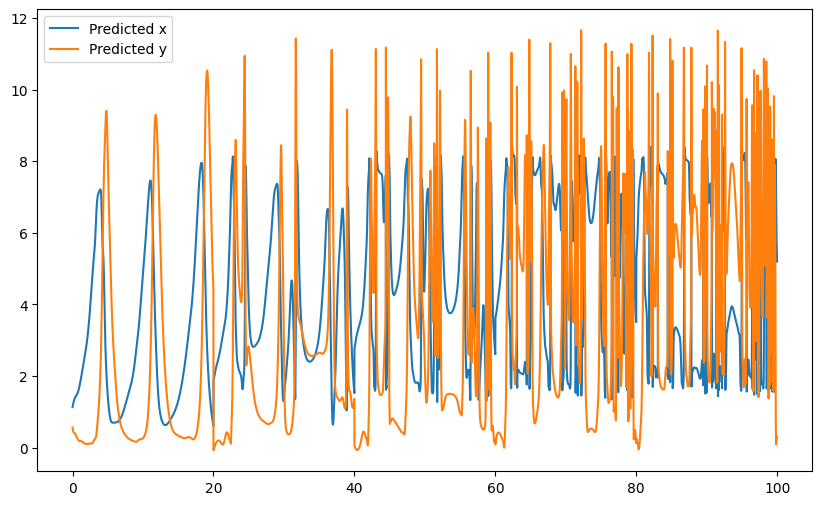

In [ ]:
# Visualize the results
net.eval()
with torch.no_grad():

    # time_tensor = torch.cat([dataset.__getitem__(i)[0] for i in range(len(dataset))]).unsqueeze(1)
    # xy_tensor = torch.stack([dataset.__getitem__(i)[1] for i in range(len(dataset))])

    time_tensor = (torch.arange(0, 2000, dtype=torch.float32))
    time_tensor = (time_tensor/100).unsqueeze(1)

    test_temp_tensor = (torch.arange(0, 10000, dtype=torch.float32))
    test_temp_tensor = (test_temp_tensor/100).unsqueeze(1)

    # xy_tensor[xy_tensor == 0.0] = float('nan')

    plt.figure(figsize=(10, 6))
    future_steps = 4
    predictions = net(time_tensor, future=future_steps)
    print(predictions)
    print(len(predictions))
    # plt.scatter(time_tensor.numpy(), xy_tensor[:, 0].numpy(), label='True x', alpha=0.2)
    # plt.scatter(time_tensor.numpy(), xy_tensor[:, 1].numpy(), label='True y', alpha=0.2)

    plt.plot(test_temp_tensor.numpy(), predictions[:, 0], label='Predicted x', alpha=1)
    plt.plot(test_temp_tensor.numpy(), predictions[:, 1], label='Predicted y', alpha=1)

    plt.legend()
    plt.show()

# Part 3-1a

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

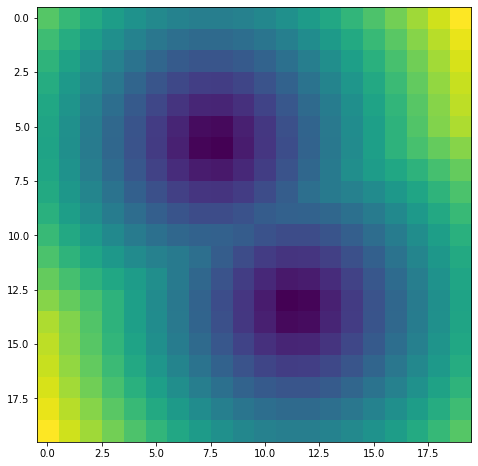


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

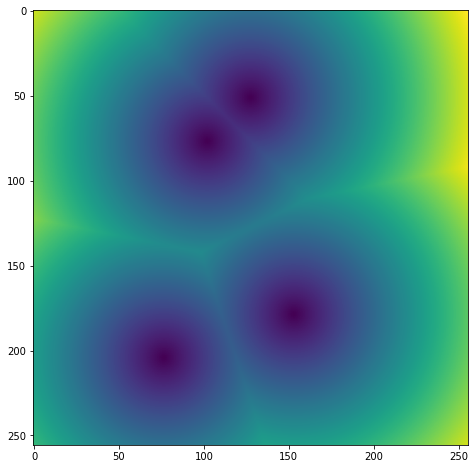


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def min_dist(points, res):
  """Calculates a 2D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a python list of 2D coordinates, normalized in the range [0,1]
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points.
  """
  # Convert points into a numpy array for easier manipulation
  points = np.array(points)

  # Generate 'res' equally spaced values from [0, 1] for x any y.
  x = np.linspace(0, 1, res)
  y = np.linspace(0, 1, res)

  # Create a 2D array of all possible coordinate combinations of x and y
  x_grid, y_grid = np.meshgrid(x, y) # shape: [res, res]


  # Flatten the grid to 1D arrays. Then combine the 1D arrays into 2D arrays again.
  # Each row represents a coordinate in the grid.
  grid_points = np.stack([x_grid.flatten(), y_grid.flatten()], axis=-1) # shape: [res*res, 2]

  # Compute the Euclidean distance from each grid point to each data point
  distances = np.linalg.norm(grid_points[:, np.newaxis] - points, axis=-1)

  # Find the minimum distance for each grid point
  min_distances = np.min(distances, axis=1)

  # Reshape back to the grid
  return min_distances.reshape(res, res)


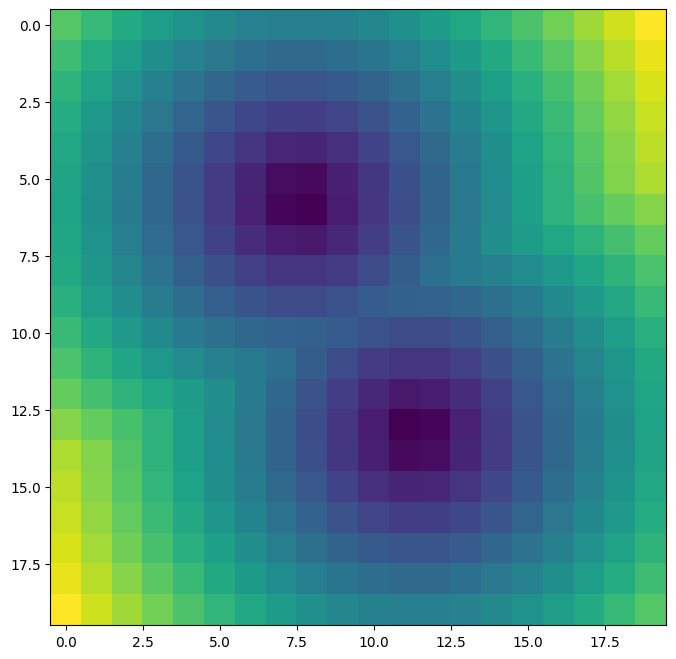

In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

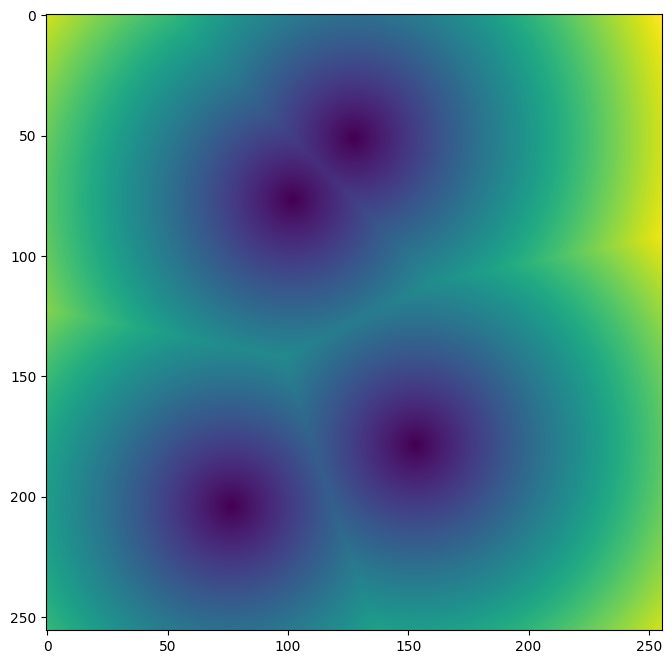

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

# Part 3-1b: Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  return coords

In [ ]:
def min_dist_batch(points, res):
  """
  Calculates a 3D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a numpy array of 2D coordinates and point values, normalized to
      be in the range [0,1]. The expected shape is [B, P, 2].
    * res: the resolution of the output tensor.

  Returns:
    A res x res square tensor with floating point values corresponding to the
    Euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].
  """
  batch_size, _, _ = points.shape

  # Generate 'res' equally spaced values from [0, 1] for x any y.
  x = np.linspace(0, 1, res)
  y = np.linspace(0, 1, res)

  # Create a 2D array of all possible coordinate combinations of x and y
  x_grid, y_grid = np.meshgrid(x, y)
  grid_points = np.stack([x_grid, y_grid], axis=-1)  # Shape: [res, res, 2]

  # Expand grid to batch size
  grid_points = np.expand_dims(grid_points, axis=0)  # Shape: [1, res, res, 2]
  grid_points = np.repeat(grid_points, batch_size, axis=0)  # Shape: [B, res, res, 2]

  # Expand grid and points for broadcasting.
  grid_points_flat = grid_points.reshape(batch_size, res * res, 1, 2)  # Shape: [B, res*res, 1, 2]
  points = points[:, np.newaxis, :, :]  # Shape: [B, 1, P, 2]

  # Compute distances
  distances = np.linalg.norm(grid_points_flat - points, axis=-1)  # Shape: [B, res*res, P]

  # Find the minimum distance along the points axis
  min_distances = np.min(distances, axis=-1)  # Shape: [B, res*res]

  # Reshape to grid shape
  return min_distances.reshape(batch_size, res, res)


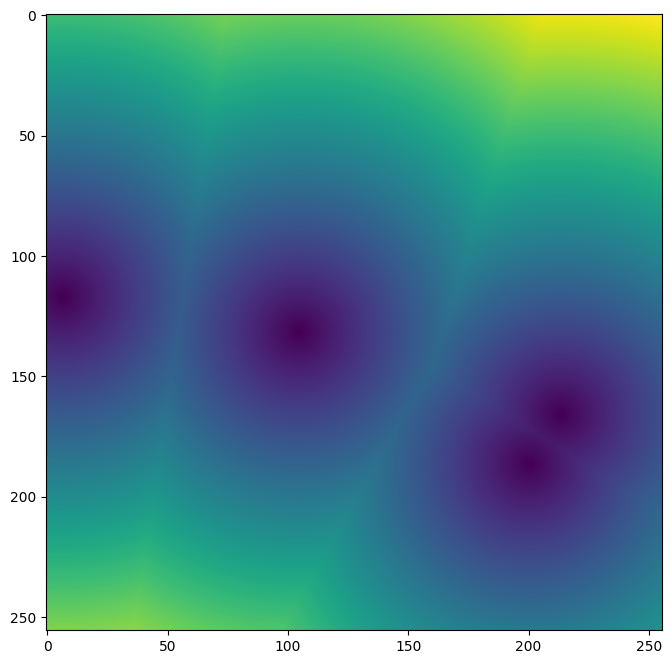

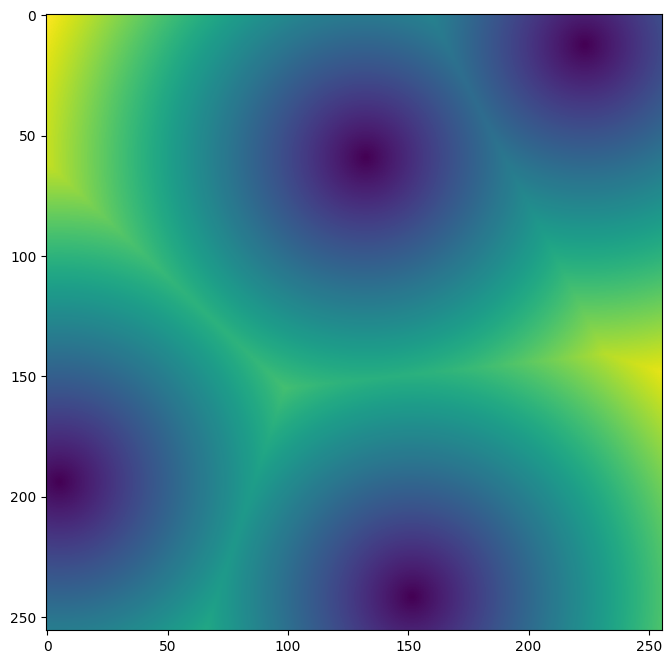

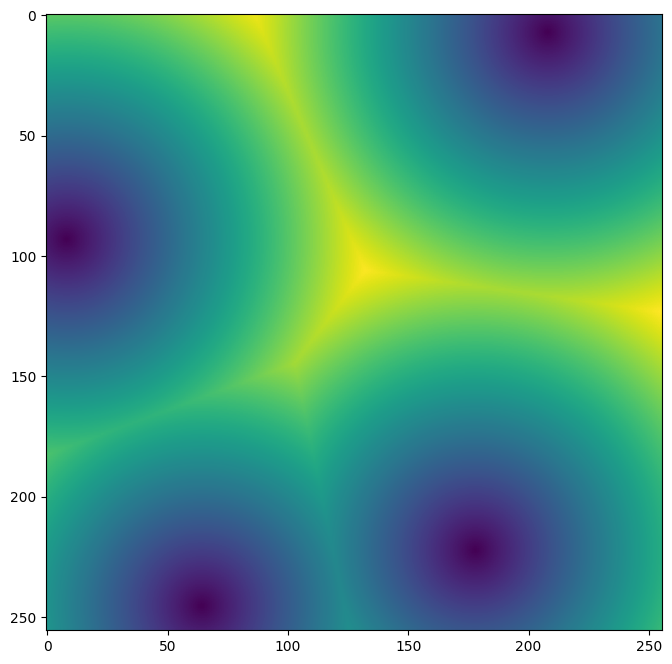

In [ ]:
points = create_points(3, 4)

# Calculate distances for each batch
for i in range(len(points)):
  distance_to_data = min_dist_batch(points, 256)[i]
  plt.figure(figsize=(8, 8))
  plt.imshow(distance_to_data)

# Part 3-2: Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

In [ ]:
def min_dist_scalable(points, res, block_size=256):
    """
    Scalable version of min_dist to handle very high resolution grids.

    Inputs:
      * points: a numpy array of 2D coordinates and point values, normalized to
        be in the range [0,1]. The expected shape is [B, P, 2].
      * res: the resolution of the output tensor.
      * block_size: size of the 2D blocks for processing.

    Returns:
      A [B, res, res] tensor of distances.
    """
    batch_size, _, _ = points.shape

    # # Generate 'res' equally spaced values from [0, 1] for x any y.
    x = np.linspace(0, 1, res)
    y = np.linspace(0, 1, res)

    # Placeholder for the final result. initialize every point with inf to ensure we compute the min distance for each block
    result = np.full((batch_size, res, res), np.inf, dtype=np.float32)

    # Loop over 2D blocks
    for y_start in range(0, res, block_size):
        y_end = min(y_start + block_size, res)
        y_chunk = y[y_start:y_end]

        for x_start in range(0, res, block_size):
            x_end = min(x_start + block_size, res)
            x_chunk = x[x_start:x_end]

            # Create the current block of grid points
            x_grid, y_grid = np.meshgrid(x_chunk, y_chunk)  # Shape: [block_size, block_size]
            grid_points = np.stack([x_grid, y_grid], axis=-1)  # Shape: [block_size, block_size, 2]

            # Expand dimensions for broadcasting
            grid_points = np.expand_dims(grid_points, axis=0)  # [1, block_size, block_size, 2]
            grid_points = np.repeat(grid_points, batch_size, axis=0)  # [B, block_size, block_size, 2]

            # Compute distances to points in the current block
            distances = np.linalg.norm(
                grid_points[:, :, :, np.newaxis, :] - points[:, np.newaxis, np.newaxis, :, :],
                axis=-1
            )  # Shape: [B, block_size, block_size, P]

            # Find the minimum distances for each pixel in the block
            min_distances = np.min(distances, axis=-1)  # Shape: [B, block_size, block_size]

            # Store the computed block in the result
            result[:, y_start:y_end, x_start:x_end] = min_distances

    return result


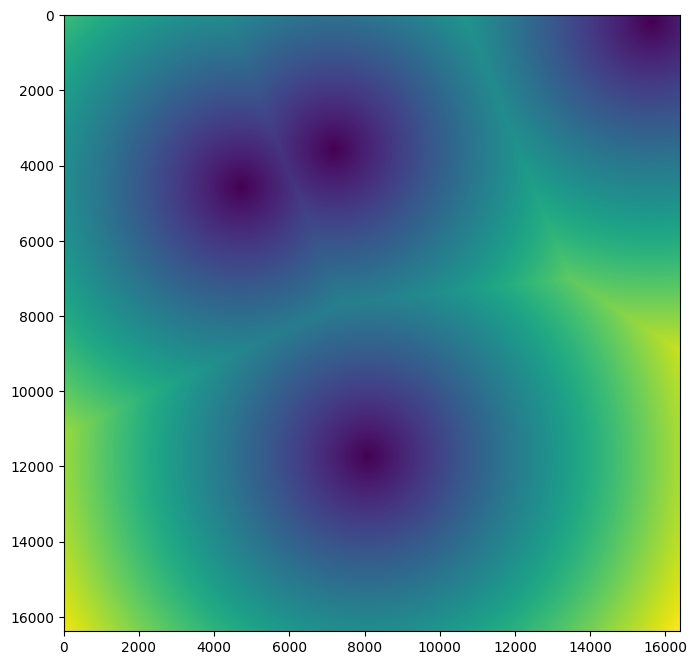

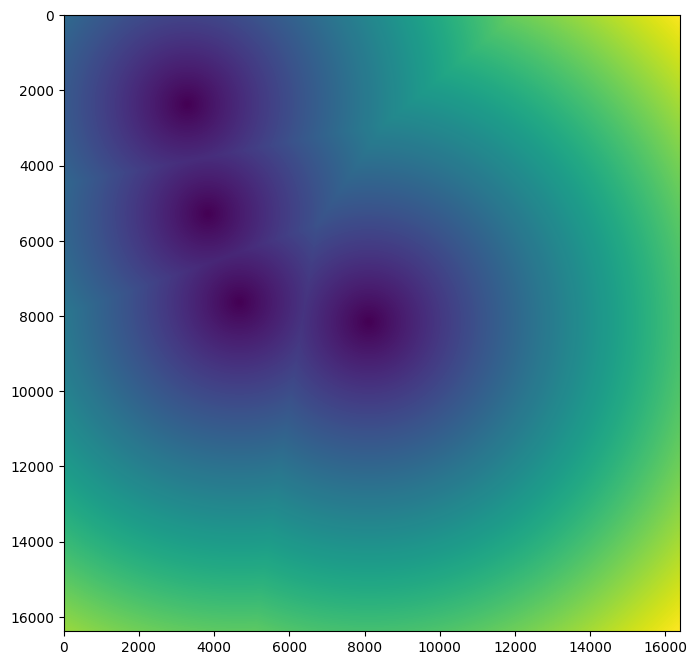

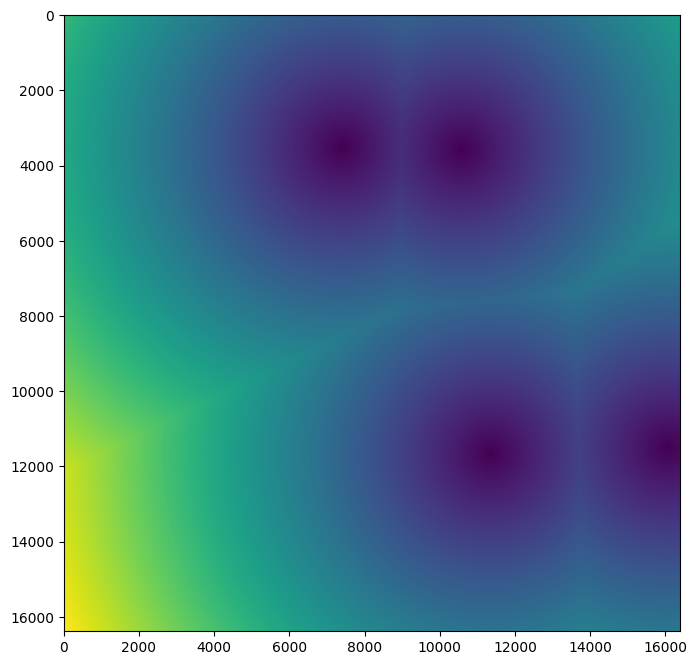

In [ ]:
points = create_points(3, 4)

# Calculate distances for each batch
for i in range(len(points)):

  distance_to_data = min_dist_scalable(points, 16384)[i]
  plt.figure(figsize=(8, 8))
  plt.imshow(distance_to_data)